# 1. Install Dependencies and Setup

In [2]:
%pip install opencv-python matplotlib




Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

/Users/adityashukla/Downloads/IrisDetection-main/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load Data

### 2.1 Load Images

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

Metal device set to: Apple M3

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2025-07-05 15:32:52.213122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-05 15:32:52.214056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [8]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return np.array(label['keypoints'], dtype=np.float32)

In [10]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
train_labels = train_labels.map(lambda x: tf.ensure_shape(x, [4]))


In [11]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
test_labels = test_labels.map(lambda x: tf.ensure_shape(x, [4]))


In [12]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
val_labels = val_labels.map(lambda x: tf.ensure_shape(x, [4]))

### 2.3. Combine Labels and Images

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(4)
train = train.prefetch(4)

In [14]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [15]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### 2.4 View Samples

In [16]:
data_samples = train.as_numpy_iterator()

In [17]:
res = data_samples.next()

2025-07-05 15:33:19.716147: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


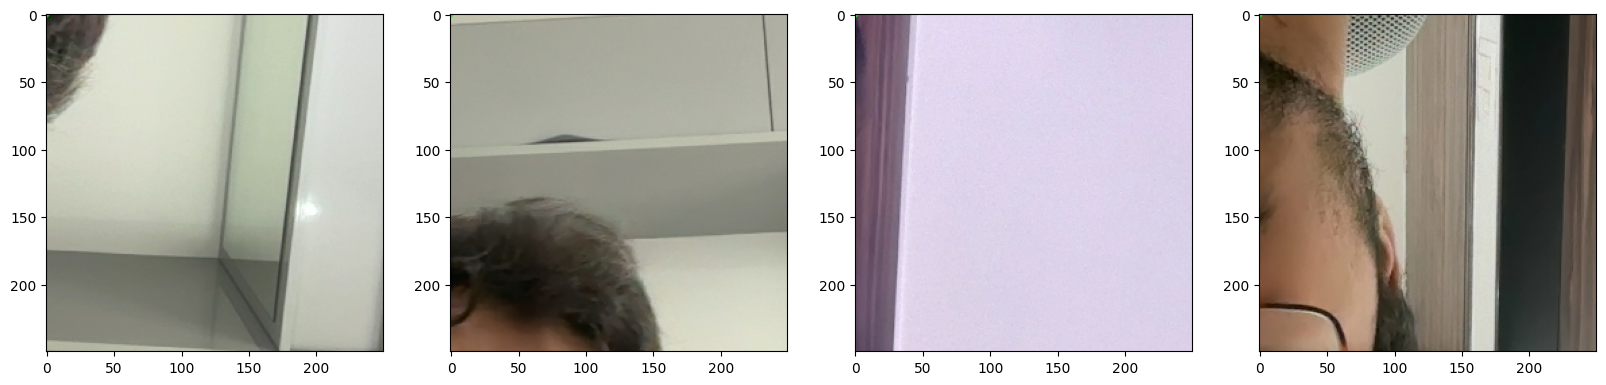

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][idx]
    
    # Convert image to uint8 for OpenCV drawing
    img_to_draw = (sample_image * 255).astype(np.uint8).copy()
    
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(img_to_draw)

# 3. Build Model

### 3.1 Create Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet50V2

In [20]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet50V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 3.2 Setup Losses and Optimizer

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [23]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [24]:
X, y = train.as_numpy_iterator().next()

In [25]:
X.shape

(4, 250, 250, 3)

In [26]:
scores = model.predict(X)

2025-07-05 15:34:07.020256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


In [27]:
scores

array([[-0.22953904, -0.13720022,  1.4243956 ,  0.7585295 ],
       [-0.6186917 , -0.20160288,  0.9212532 ,  0.4077707 ],
       [-0.440269  , -0.71035194,  0.8854073 ,  1.3062885 ],
       [-0.6123392 ,  0.35472202,  1.0318791 ,  0.6208992 ]],
      dtype=float32)

### 3.4 Train the Model

In [28]:
# Train for 100 epochs

hist = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100


2025-07-05 15:34:14.574562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


597/597 [==============================] - ETA: 0s - loss: 0.2297

2025-07-05 15:35:50.477224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


597/597 [==============================] - 112s 167ms/step - loss: 0.2297 - val_loss: 0.0360
Epoch 2/100
597/597 [==============================] - 186s 300ms/step - loss: 0.0270 - val_loss: 0.0210
Epoch 3/100
597/597 [==============================] - 147s 239ms/step - loss: 0.0200 - val_loss: 0.0190
Epoch 4/100
597/597 [==============================] - 153s 249ms/step - loss: 0.0169 - val_loss: 0.0184
Epoch 5/100
597/597 [==============================] - 177s 286ms/step - loss: 0.0154 - val_loss: 0.0179
Epoch 6/100
597/597 [==============================] - 143s 234ms/step - loss: 0.0144 - val_loss: 0.0197
Epoch 7/100
597/597 [==============================] - 147s 240ms/step - loss: 0.0132 - val_loss: 0.0164
Epoch 8/100
597/597 [==============================] - 158s 255ms/step - loss: 0.0108 - val_loss: 0.0147
Epoch 9/100
597/597 [==============================] - 164s 269ms/step - loss: 0.0080 - val_loss: 0.0137
Epoch 10/100
597/597 [==============================] - 173s 284ms/

2025-07-05 16:10:49.899430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1388 of 5000
2025-07-05 16:10:58.575988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


597/597 [==============================] - 205s 286ms/step - loss: 0.0052 - val_loss: 0.0122
Epoch 16/100
597/597 [==============================] - 174s 286ms/step - loss: 0.0029 - val_loss: 0.0088
Epoch 17/100
597/597 [==============================] - 214s 342ms/step - loss: 0.0013 - val_loss: 0.0076
Epoch 18/100
597/597 [==============================] - 159s 257ms/step - loss: 0.0010 - val_loss: 0.0082
Epoch 19/100
597/597 [==============================] - 129s 211ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 20/100
597/597 [==============================] - 143s 234ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 21/100
597/597 [==============================] - 137s 224ms/step - loss: 0.0022 - val_loss: 0.0085
Epoch 22/100
597/597 [==============================] - 140s 229ms/step - loss: 0.0028 - val_loss: 0.0106
Epoch 23/100
597/597 [==============================] - 132s 217ms/step - loss: 0.0021 - val_loss: 0.0096
Epoch 24/100
597/597 [==============================] - 128

In [29]:
model.save("iris_estimation_model_final.h5")
model.evaluate(test)

65/65 [==============================] - 7s 87ms/step - loss: 0.0028


0.00284595531411469

# 4. Review Performance

### 4.1 View Loss Plots

In [30]:
hist.history

{'loss': [0.229735866189003,
  0.026954105123877525,
  0.02003229595720768,
  0.016922088339924812,
  0.015437541529536247,
  0.014448639005422592,
  0.013182166963815689,
  0.01075657457113266,
  0.007962151430547237,
  0.005779494997113943,
  0.004328064154833555,
  0.0023981386329978704,
  0.002959794830530882,
  0.006187499035149813,
  0.005228988826274872,
  0.002916576573625207,
  0.0013452765997499228,
  0.0010125484550371766,
  0.001828809268772602,
  0.0023084760177880526,
  0.002195966662839055,
  0.0028010362293571234,
  0.0020585726015269756,
  0.001129746320657432,
  0.0008731507114134729,
  0.0005257694865576923,
  0.0004143526894040406,
  0.000519976660143584,
  0.0016380591550841928,
  0.0009599847253412008,
  0.0006204767851158977,
  0.001288875238969922,
  0.00040545235970057547,
  0.0007667247555218637,
  0.00042996188858523965,
  0.0003965871292166412,
  0.00048639081069268286,
  0.0003213883610442281,
  0.00019241365953348577,
  0.0007423581555485725,
  0.000362042

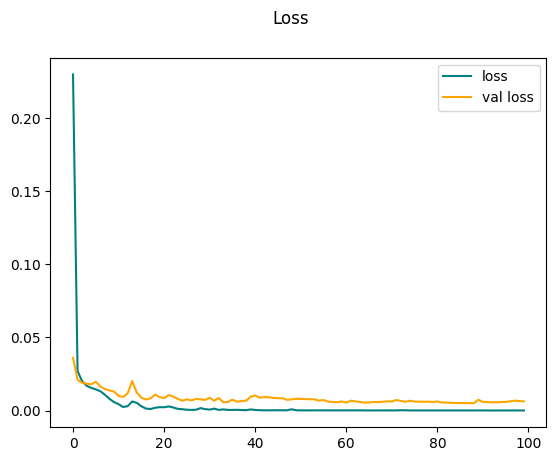

In [31]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

In [32]:
test_data = test.as_numpy_iterator()

In [33]:
test_sample = test_data.next()

In [34]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


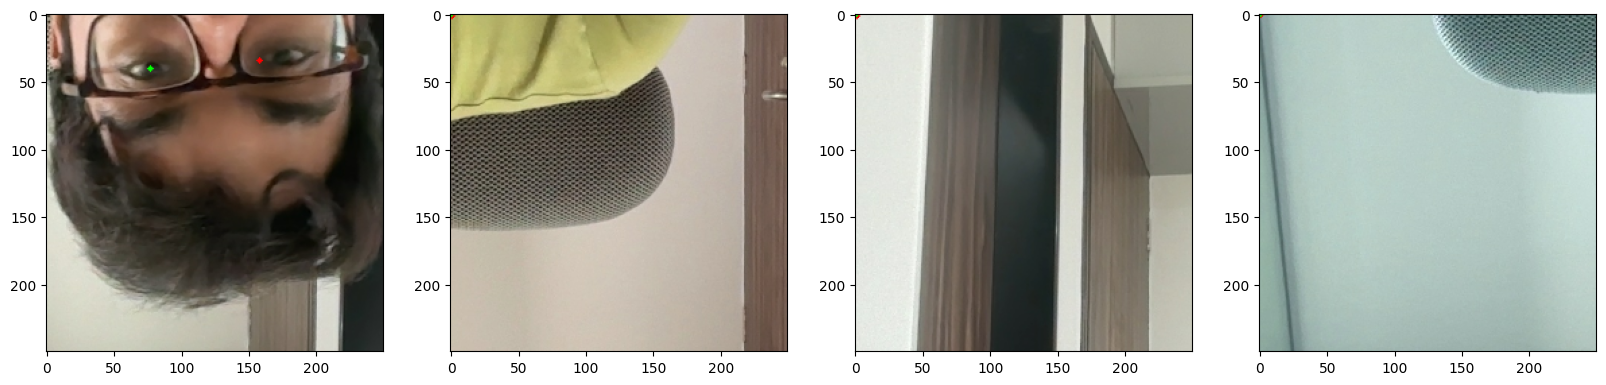

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    # Make a writable copy
    img_to_draw = sample_image.copy()
    
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(img_to_draw, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(img_to_draw)

### 4.3. Save the Model

In [37]:
from tensorflow.keras.models import load_model

In [38]:
model.save('eyetrackerresnet.h5')

In [39]:
model = load_model('eyetrackerresnet.h5')

In [40]:
model.predict(test_sample[0])

2025-07-05 20:00:38.464232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


array([[ 6.3560450e-01,  1.3990197e-01,  3.0900493e-01,  1.6095631e-01],
       [ 5.2988864e-03,  5.6136847e-03, -9.7480789e-04,  3.8968287e-03],
       [ 5.3047538e-03,  4.0559843e-03, -6.6167861e-04,  3.2695942e-03],
       [ 5.5349320e-03,  3.7011802e-03, -6.8970397e-04,  3.6140569e-03],
       [ 5.3317225e-01,  5.1493621e-01,  1.5234986e-01,  4.7903150e-01],
       [ 5.0764158e-03,  3.7823692e-03,  1.4629588e-04,  2.5845580e-03],
       [ 4.8429631e-03,  3.5583377e-03, -4.8911199e-04,  3.3185445e-03],
       [ 5.1863529e-03,  3.5860762e-03, -6.7748129e-04,  2.6083663e-03]],
      dtype=float32)

In [48]:
import numpy as np

def calculate_pixel_accuracy(y_pred, y_true, image_size=250, tolerance=10):
    """
    Calculate pixel accuracy and average distance for eye detection.
    Args:
        y_pred: np.array, shape (N, 4), normalized predictions
        y_true: np.array, shape (N, 4), normalized ground truth
        image_size: int, size of the image (250 for your case)
        tolerance: int, max allowed distance in pixels for a correct prediction
    Returns:
        accuracy: float, percentage of samples where both eyes are within tolerance
        avg_distance: float, average pixel distance across all keypoints
    """
    # Denormalize
    y_pred_px = y_pred * image_size
    y_true_px = y_true * image_size

    correct = 0
    total = y_pred.shape[0]
    distances = []

    for pred, gt in zip(y_pred_px, y_true_px):
        left_dist = np.linalg.norm(pred[:2] - gt[:2])
        right_dist = np.linalg.norm(pred[2:] - gt[2:])
        distances.extend([left_dist, right_dist])
        if left_dist <= tolerance and right_dist <= tolerance:
            correct += 1

    accuracy = correct / total
    avg_distance = np.mean(distances)
    return accuracy, avg_distance

# --- Run this on your test set ---
# Collect all predictions and ground truths
y_true = []
y_pred = []
for images, labels in test:
    preds = model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Calculate accuracy and average distance
accuracy, avg_distance = calculate_pixel_accuracy(y_pred, y_true, image_size=250, tolerance=10)
print(f"Pixel accuracy (both eyes within 5px): {accuracy:.2%}")
print(f"Average keypoint distance: {avg_distance:.2f} pixels")

1/1 [==============================] - 0s 33ms/step
Pixel accuracy (both eyes within 5px): 82.75%
Average keypoint distance: 5.47 pixels


# 5. Real Time Detection

In [45]:
cap = cv2.VideoCapture(0)
cv2.namedWindow('EyeTrack', cv2.WINDOW_NORMAL)

while cap.isOpened():
    _, frame = cap.read()
    # Remove cropping: use the full frame
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250, 250))
    
    yhat = model.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[0, :4]  # normalized coordinates

    # Draw on the original frame using its actual size
    h, w = frame.shape[:2]
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [w, h]).astype(int)), 2, (255, 0, 0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [w, h]).astype(int)), 2, (0, 255, 0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step
